Descriptive Statistics of Surface Area (All Data):
        Extracted     In-Situ
count  180.000000  180.000000
mean     1.093940    1.370422
std      0.629584    0.372834
min      0.000000    0.622759
25%      0.630000    1.069177
50%      1.342350    1.438909
75%      1.654650    1.686738
max      1.753200    1.863290


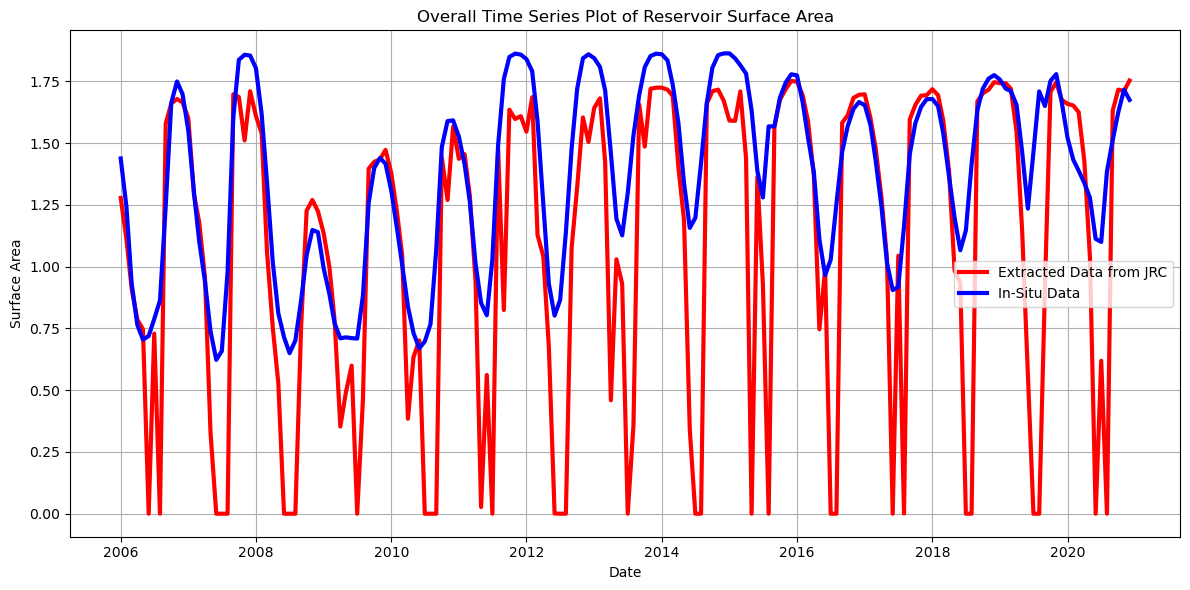

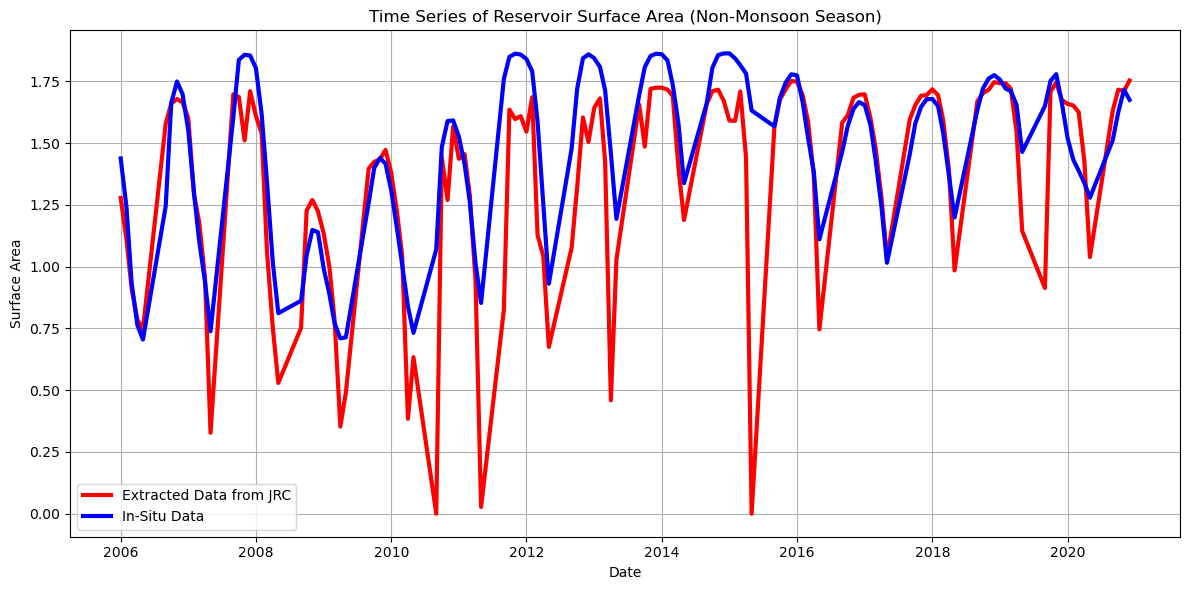

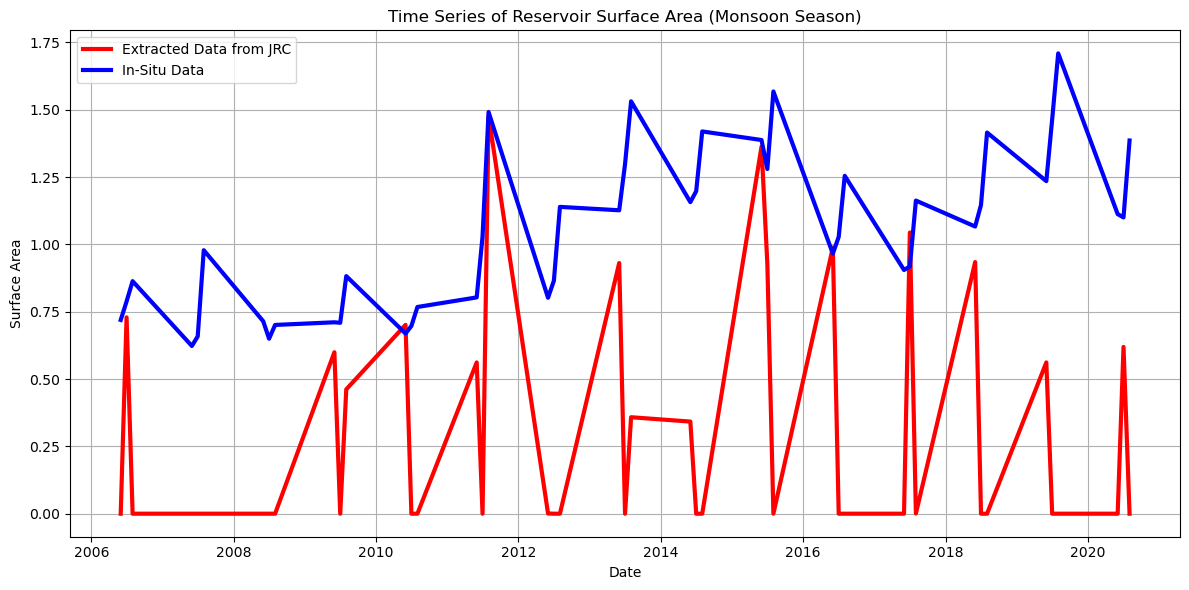


Non-Monsoon Season Regression Metrics:
Mean Squared Error: 0.0316
Mean Absolute Error: 0.1330
R-squared: 0.71


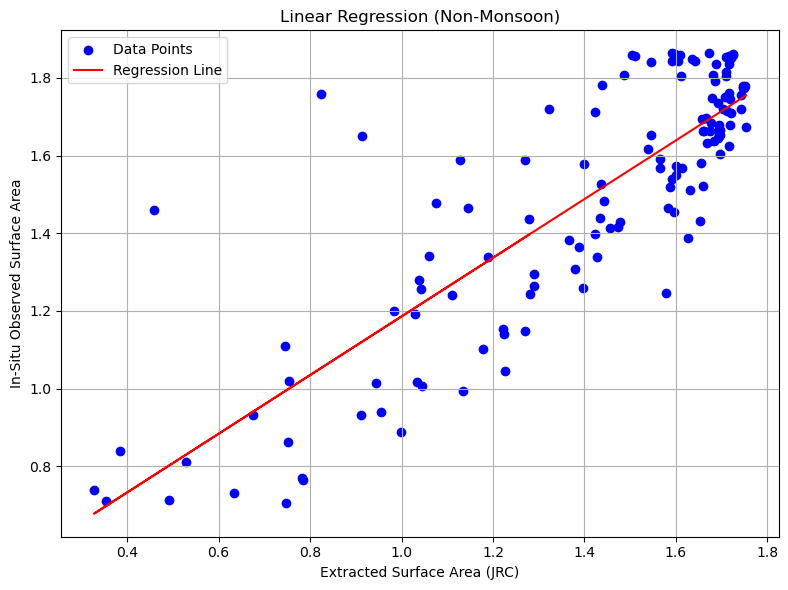


Overall Error Metrics:
Mean Absolute Error: 0.3200
Mean Relative Error: 27.91%

Monsoon Season Error Metrics:
Mean Absolute Error: 0.7745
Mean Relative Error: 73.93%

Non-Monsoon Season Error Metrics:
Mean Absolute Error: 0.1684
Mean Relative Error: 12.57%


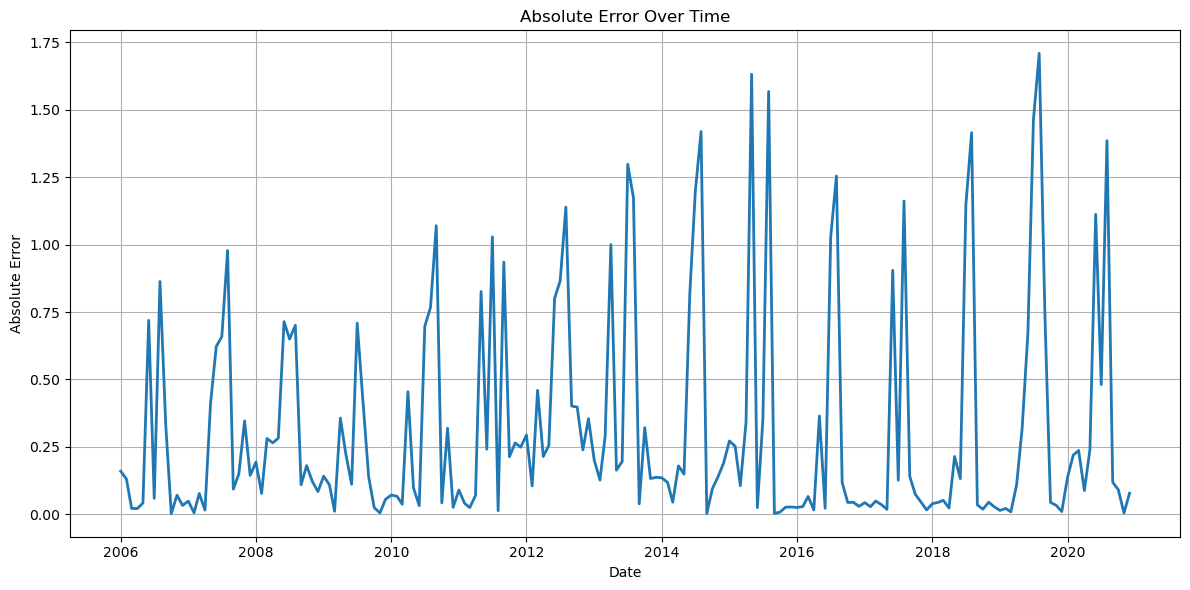

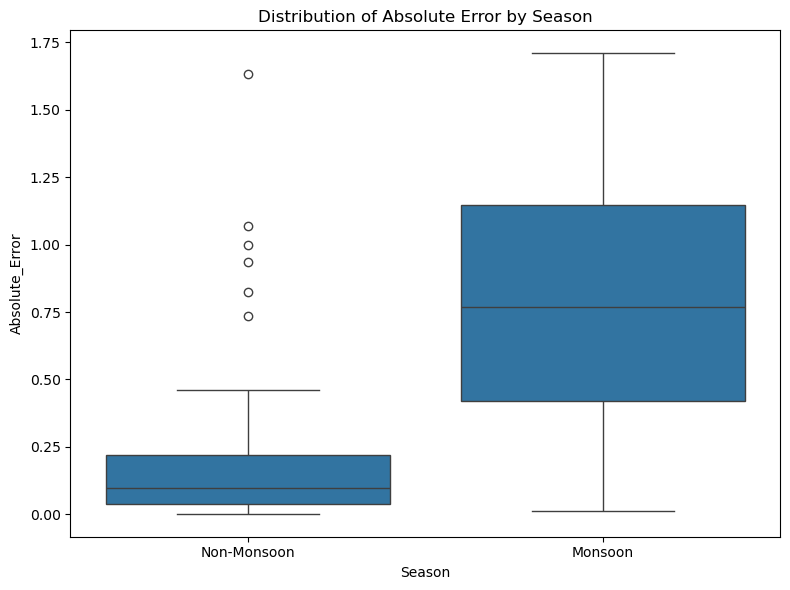


Non-Monsoon Seasonal Error Metrics:
Mean Absolute Error: 0.1684
Mean Relative Error: 12.57%


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv('comparisondata2006_2020.csv')

df = df.drop_duplicates()

df['Month'] = df['Month'].str.strip().str.capitalize()

df['Extracted'] = pd.to_numeric(df['Extracted'], errors='coerce')
df['In-Situ'] = pd.to_numeric(df['In-Situ'], errors='coerce')

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B', errors='coerce')

df = df.dropna(subset=['Date'])

df = df.sort_values('Date').reset_index(drop=True)

if df.isnull().values.any():
    print("Warning: The dataset contains missing values.")

monsoon_months = ['June', 'July', 'August']
df['Season'] = df['Month'].apply(lambda x: 'Monsoon' if x in monsoon_months else 'Non-Monsoon')

print("Descriptive Statistics of Surface Area (All Data):")
print(df[['Extracted', 'In-Situ']].describe())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Extracted'], label='Extracted Data from JRC', color='r', linewidth=3)
plt.plot(df['Date'], df['In-Situ'], label='In-Situ Data', color='b', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Surface Area')
plt.title('Overall Time Series Plot of Reservoir Surface Area')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_monsoon = df[df['Season'] == 'Monsoon'].copy()
df_non_monsoon = df[df['Season'] == 'Non-Monsoon'].copy()

plt.figure(figsize=(12, 6))
plt.plot(df_non_monsoon['Date'], df_non_monsoon['Extracted'], label='Extracted Data from JRC', color='r', linewidth=3)
plt.plot(df_non_monsoon['Date'], df_non_monsoon['In-Situ'], label='In-Situ Data', color='b', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Surface Area')
plt.title('Time Series of Reservoir Surface Area (Non-Monsoon Season)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_monsoon['Date'], df_monsoon['Extracted'], label='Extracted Data from JRC', color='r', linewidth=3)
plt.plot(df_monsoon['Date'], df_monsoon['In-Situ'], label='In-Situ Data', color='b', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Surface Area')
plt.title('Time Series of Reservoir Surface Area (Monsoon Season)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Q1_extracted = df_non_monsoon['Extracted'].quantile(0.25)
Q3_extracted = df_non_monsoon['Extracted'].quantile(0.75)
IQR_extracted = Q3_extracted - Q1_extracted

Q1_insitu = df_non_monsoon['In-Situ'].quantile(0.25)
Q3_insitu = df_non_monsoon['In-Situ'].quantile(0.75)
IQR_insitu = Q3_insitu - Q1_insitu

lower_bound_extracted = Q1_extracted - 1.5 * IQR_extracted
upper_bound_extracted = Q3_extracted + 1.5 * IQR_extracted

lower_bound_insitu = Q1_insitu - 1.5 * IQR_insitu
upper_bound_insitu = Q3_insitu + 1.5 * IQR_insitu

df_non_monsoon_no_outliers = df_non_monsoon[
    (df_non_monsoon['Extracted'] >= lower_bound_extracted) &
    (df_non_monsoon['Extracted'] <= upper_bound_extracted) &
    (df_non_monsoon['In-Situ'] >= lower_bound_insitu) &
    (df_non_monsoon['In-Situ'] <= upper_bound_insitu)
].copy()

X_no_outliers = df_non_monsoon_no_outliers['Extracted'].values.reshape(-1, 1)
y_no_outliers = df_non_monsoon_no_outliers['In-Situ'].values

model_no_outliers = LinearRegression()
model_no_outliers.fit(X_no_outliers, y_no_outliers)

df_non_monsoon_no_outliers['Predicted_In-Situ'] = model_no_outliers.predict(X_no_outliers)
df_non_monsoon_no_outliers['Residuals'] = df_non_monsoon_no_outliers['In-Situ'] - df_non_monsoon_no_outliers['Predicted_In-Situ']

mse_no_outliers = mean_squared_error(y_no_outliers, df_non_monsoon_no_outliers['Predicted_In-Situ'])
mae_no_outliers = mean_absolute_error(y_no_outliers, df_non_monsoon_no_outliers['Predicted_In-Situ'])
r2_no_outliers = r2_score(y_no_outliers, df_non_monsoon_no_outliers['Predicted_In-Situ'])

print(f"\nNon-Monsoon Season Regression Metrics:")
print(f"Mean Squared Error: {mse_no_outliers:.4f}")
print(f"Mean Absolute Error: {mae_no_outliers:.4f}")
print(f"R-squared: {r2_no_outliers:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(df_non_monsoon_no_outliers['Extracted'], df_non_monsoon_no_outliers['In-Situ'], label='Data Points', color='blue')
plt.plot(df_non_monsoon_no_outliers['Extracted'], df_non_monsoon_no_outliers['Predicted_In-Situ'], color='red', label='Regression Line')
plt.xlabel('Extracted Surface Area (JRC)')
plt.ylabel('In-Situ Observed Surface Area')
plt.title('Linear Regression (Non-Monsoon)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


df['Absolute_Error'] = abs(df['Extracted'] - df['In-Situ'])
df['Relative_Error_%'] = (df['Absolute_Error'] / df['In-Situ'].replace({0: np.nan})) * 100

mean_abs_error = df['Absolute_Error'].mean()
mean_rel_error = df['Relative_Error_%'].mean()

print(f"\nOverall Error Metrics:")
print(f"Mean Absolute Error: {mean_abs_error:.4f}")
print(f"Mean Relative Error: {mean_rel_error:.2f}%")

for season in ['Monsoon', 'Non-Monsoon']:
    df_season = df[df['Season'] == season]
    mean_abs_error_season = df_season['Absolute_Error'].mean()
    mean_rel_error_season = df_season['Relative_Error_%'].mean()
    print(f"\n{season} Season Error Metrics:")
    print(f"Mean Absolute Error: {mean_abs_error_season:.4f}")
    print(f"Mean Relative Error: {mean_rel_error_season:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Absolute_Error'], linewidth = 2)
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.title('Absolute Error Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Season', y='Absolute_Error', data=df)
plt.title('Distribution of Absolute Error by Season')
plt.tight_layout()
plt.show()

df_non_monsoon['Absolute_Error'] = abs(df_non_monsoon['Extracted'] - df_non_monsoon['In-Situ'])
df_non_monsoon['Relative_Error_%'] = (df_non_monsoon['Absolute_Error'] / df_non_monsoon['In-Situ'].replace({0: np.nan})) * 100
mean_abs_error_nm = df_non_monsoon['Absolute_Error'].mean()
mean_rel_error_nm = df_non_monsoon['Relative_Error_%'].mean()

print(f"\nNon-Monsoon Seasonal Error Metrics:")
print(f"Mean Absolute Error: {mean_abs_error_nm:.4f}")
print(f"Mean Relative Error: {mean_rel_error_nm:.2f}%")
